# Delayed and non-stationary multi-armed bandit problems

The traditional setup for multi-armed bandits is that the reward is given immediately after the action is taken. However, in many real-world applications, the reward is delayed. For example, in dynamic pricing, the reward is given after the customer makes the purchase, which can be days or weeks after the price is set. The problem becomes more complicated if the bandit is non-stationary, i.e., the reward distribution changes over time. In this notebook, we will show how to use `bayesianbandits` to approach this family of problems.

## How can we implement a geographic pricing strategy?

Suppose we are a company that sells a product in multiple cities. We want to maximize our profit by setting the price for each city. The demand for the product is different in each city, and the demand changes over time. We want to learn the demand distribution for each city and set the price accordingly. The reward is the profit, which is the price minus the cost. The cost is the same for all cities, so we can ignore it for now, and we'll make the simplifying assumption that supply is infinite.

## Simulating the problem

We will simulate the problem using the GeographicPricing class.


In [1]:
import numpy as np

np.random.seed(2)


class GeographicPricing:
    def __init__(self, num_locations: int):
        # Randomly generate demand parameters for each location
        self.demand_intercepts = np.random.uniform(low=50, high=100, size=num_locations)
        self.demand_slopes = np.random.uniform(low=-2, high=-0.1, size=num_locations)

        self.num_locations = num_locations

    def demand(self, location: int, price: int) -> float:
        # Linear demand function
        return max(
            self.demand_intercepts[location] + self.demand_slopes[location] * price, 0
        )

    def margin(self, location: int, price: int) -> float:
        # Margin is price times demand, as we're assuming zero marginal cost
        return price * self.demand(location, price)

    def adjust_demand(self):
        # Time-based step changes
        if hasattr(self, 'step_counter'):
            self.step_counter += 1
        else:
            self.step_counter = 0
        
        # Create step changes at fixed intervals
        if self.step_counter % 20 == 0:
            # Alternate between increasing and decreasing steps
            direction = 1 if (self.step_counter // 20) % 2 == 0 else -1
            step_size_intercept = direction * np.abs(np.random.uniform(8, 20, size=self.num_locations))
            step_size_slope = direction * np.abs(np.random.uniform(0.1, 0.5, size=self.num_locations))
            
            self.demand_intercepts += step_size_intercept
            self.demand_slopes += step_size_slope
        
        # Constant upward drift for all locations
        drift_intercept = np.full(self.num_locations, 0.05)  # fixed small positive drift
        drift_slope = np.full(self.num_locations, 0.001)    # fixed small positive drift
        
        self.demand_intercepts += drift_intercept
        self.demand_slopes += drift_slope
        
        # Ensure demand parameters stay within reasonable bounds
        self.demand_intercepts = np.clip(self.demand_intercepts, 20, 150)
        self.demand_slopes = np.clip(self.demand_slopes, -3, -0.05)

    def reset_demand(self):
        # Reset demand parameters to original values
        self.demand_intercepts = np.random.uniform(
            low=50, high=100, size=self.num_locations
        )
        self.demand_slopes = np.random.uniform(
            low=-2, high=-0.1, size=self.num_locations
        )


oracle = GeographicPricing(10)

We'll again use Thompson sampling as the bandit algorithm. We'll have a global intercept, as well as an intercept for each location. This, combined with the regularization behavior of the `NormalInverseGamma` regressor, will create a sort of "poor man's hierarchical model" where the intercepts for each location are pulled towards the global intercept. Let's say from historical data, we know that we make about 1000 dollars per market per day, so we'll set the prior for the mean of the global intercept to 1000, and all others to 0.

First, we'll define our action space. To keep things single, we'll consider a discrete action space with 5 possible prices:


In [2]:
from enum import Enum


class Price(Enum):
    price_5 = 5
    price_8 = 8
    price_11 = 11
    price_14 = 14
    price_17 = 17

    def take_action(self, location: int) -> float:
        return oracle.margin(location, self.value)

Next, we'll create our `ContextualAgent`.


In [3]:
from bayesianbandits import NormalInverseGammaRegressor, Arm, ContextualAgent, ThompsonSampling

est = NormalInverseGammaRegressor(mu=np.array([1000] + [0] * 10))
policy = ThompsonSampling()

arms = [
    Arm(
        Price.price_5,
        learner=NormalInverseGammaRegressor(mu=np.array([1000] + [0] * 10)),
    ),
    Arm(
        Price.price_8,
        learner=NormalInverseGammaRegressor(mu=np.array([1000] + [0] * 10)),
    ),
    Arm(
        Price.price_11,
        learner=NormalInverseGammaRegressor(mu=np.array([1000] + [0] * 10)),
    ),
    Arm(
        Price.price_14,
        learner=NormalInverseGammaRegressor(mu=np.array([1000] + [0] * 10)),
    ),
    Arm(
        Price.price_17,
        learner=NormalInverseGammaRegressor(mu=np.array([1000] + [0] * 10)),
    ),
]

agent = ContextualAgent(arms=arms, policy=policy, random_seed=111)

For the first round, we'll assume that demand is constant, so our measure of success will be the Bandit learning the true demand distribution. However, we only get to update our agent once per day, so we'll have to make decisions for all 10 cities at once, then gather the rewards.

In this simulation, the reward for any city-price combination is constant over time, so computing regret is easy. We just have to figure out the best price for each city, and compute the difference between that and the price we chose.


In [4]:
one_hot_encoding = np.append(np.ones((10, 1)), np.eye(10), axis=-1)

regret: list[float] = []

best_price_per_city = np.array(
    [
        [oracle.margin(location, price.value) for price in Price]
        for location in range(10)
    ]
).max(axis=1)

for iteration in range(365):
    # Pick prices for each location
    decisions = agent.pull(one_hot_encoding)

    # End of the day, collect rewards
    rewards = [token.take_action(location) for location, token in enumerate(decisions)]
    regret.append((best_price_per_city - np.array(rewards)).sum())

    # Update the agent
    for token, reward, context_row in zip(decisions, rewards, one_hot_encoding):
        agent.select_for_update(token).update(
            np.atleast_2d(context_row), np.atleast_1d(reward)
        )

We can see that the agent achieves sublinear regret quick quickly.


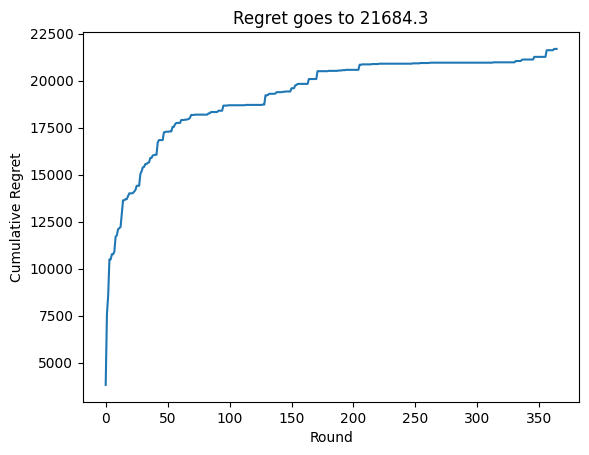

In [5]:
import matplotlib.pyplot as plt

cumsum_regret = np.cumsum(regret)
plt.plot(cumsum_regret)
plt.xlabel("Round")
plt.ylabel("Cumulative Regret")
plt.title(f"Regret goes to {cumsum_regret[-1]:0.1f}")

summary_of_regrets = {'Regret without drift': cumsum_regret[-1]}

Because we chose a linear demand function, we know for a fact that the $17 price is optimal for all cities. We can see that the agent's learned expected reward per city for the $17 price is very close to the true maximum reward.


In [6]:
agent.arm(Price.price_17).learner.coef_[0] + agent.arm(Price.price_17).learner.coef_[1:]

array([ 983.33767956,  585.41559973,  813.26377844,  923.87194944,
        730.97891108,  983.68947175,  914.73751899, 1069.20622452,
        991.20894477,  543.60804735])

In [7]:
best_price_per_city

array([ 983.66025439,  584.58922102,  813.11095419,  924.02978011,
        730.588562  ,  984.01212752,  914.86917212, 1069.7657688 ,
        991.55338423,  542.53651526])

While that was a fun simulation, it's not very realistic. In reality, demand changes over time. Let's simulate that by making the demand for each city a step function with some drift (given by the the `adjust_demand` method above). This is still fairly unrealistic, but we can use this setting to see how the agent performs when the demand is non-stationary.

We'll define some helper functions to focus on the most interesting part of the simulation.


In [8]:
def build_contextual_agent(policy, prior_mean: np.ndarray = np.array([1000] + [0] * 10),
                            random_seed: int = 111) -> ContextualAgent:
    return ContextualAgent(
    arms=[
        Arm(
            Price.price_5,
            learner=NormalInverseGammaRegressor(mu=prior_mean),
        ),
        Arm(
            Price.price_8,
            learner=NormalInverseGammaRegressor(mu=prior_mean),
        ),
        Arm(
            Price.price_11,
            learner=NormalInverseGammaRegressor(mu=prior_mean),
        ),
        Arm(
            Price.price_14,
            learner=NormalInverseGammaRegressor(mu=prior_mean),
        ),
        Arm(
            Price.price_17,
            learner=NormalInverseGammaRegressor(mu=prior_mean),
        ),
    ],
    policy=policy,
    random_seed=random_seed,
    )


def compute_best_price_per_city(oracle: GeographicPricing) -> np.ndarray:
    best_price_per_city = np.array(
        [
            [oracle.margin(location, price.value) for price in Price]
            for location in range(10)
        ]
    ).max(axis=1)

    return best_price_per_city


In [9]:
agent = build_contextual_agent(policy=policy)

np.random.seed(2)
one_hot_encoding = np.append(np.ones((10, 1)), np.eye(10), axis=-1)

oracle.reset_demand()
regret: list[float] = []

for iteration in range(1000):
    # Start of each week, randomly adjust demand
    if iteration % 7 == 0:
        oracle.adjust_demand()

    # Recompute best price per city
    best_price_per_city = compute_best_price_per_city(oracle)

    # Start of the day, adjust prices
    decisions = agent.pull(one_hot_encoding)

    # End of the day, collect rewards
    rewards = [token.take_action(location) for location, token in enumerate(decisions)]
    regret.append((best_price_per_city - np.array(rewards)).sum())
    
    # Update the agent
    for token, reward, context_row in zip(decisions, rewards, one_hot_encoding):
        agent.select_for_update(token).update(
            np.atleast_2d(context_row), np.atleast_1d(reward)
        )

Now, we see that the agent's performance is much worse. This is because the agent is not able to adapt to the changing demand. As we can see in the below plot, the agent begins to learn the true demand distribution, but then it changes, and the agent has already found a very narrow posterior distribution for the demand. Unfortunately, this posterior is out of date, so the agent will be slow to adapt.


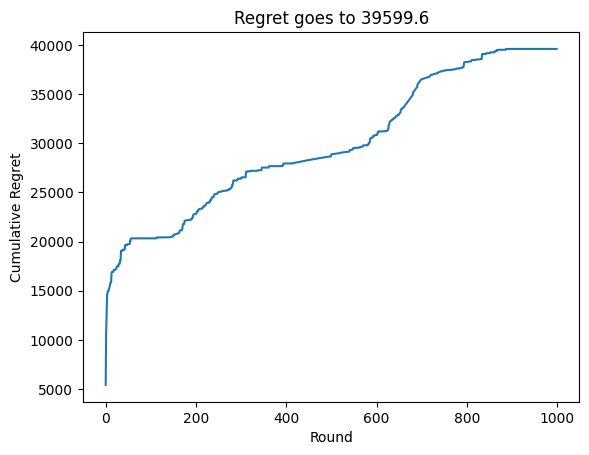

In [10]:
import matplotlib.pyplot as plt

plt.plot(np.cumsum(regret))
plt.xlabel("Round")
plt.ylabel("Cumulative Regret")
regret_without_decay = np.cumsum(regret)[-1]
plt.title(f"Regret goes to {regret_without_decay:0.1f}")
summary_of_regrets['Regret without decay'] = regret_without_decay

Instead, we can utilize the `Agent.decay` method to increase the variance of our posterior distributions, thereby encouraging the agent to maintain a baseline level of exploration. The choice of `decay_rate` is arbitrary, it is essentially an exponential decay rate that increases the variance of the posterior distributions. We can see that this helps the agent adapt to the changing demand. However, decaying too often can prevent the agent from ever learning how to maximize the reward.

We will write a function to run the whole simulation so we can then tune the `decay_rate` hyperparameter. We'll start with `decay_rate` = 0.98 just to see how it goes.

In [11]:

def run_decay_simulation(decay_rate: float, oracle: GeographicPricing) -> list[float]:
    np.random.seed(2)

    oracle.reset_demand()

    agent = build_contextual_agent(policy=policy)
            
    one_hot_encoding = np.append(np.ones((10, 1)), np.eye(10), axis=-1)

    regret: list[float] = []

    for iteration in range(1000):
        # Start of each week, randomly adjust demand
        if iteration % 7 == 0:
            oracle.adjust_demand()

        # Recompute best price per city
        best_price_per_city = compute_best_price_per_city(oracle)

        # Start of the day, adjust prices
        decisions = agent.pull(one_hot_encoding)

        # End of the day, collect rewards
        rewards = [token.take_action(location) for location, token in enumerate(decisions)]
        regret.append((best_price_per_city - np.array(rewards)).sum())
        
        # Update the agent
        for token, reward, context_row in zip(decisions, rewards, one_hot_encoding):
            agent.select_for_update(token).update(
                np.atleast_2d(context_row), np.atleast_1d(reward)
            )

        # End of each month, decay the bandit
        if iteration % 30 == 0:
            agent.decay(one_hot_encoding[0], decay_rate=decay_rate)

    return regret

regret = run_decay_simulation(0.98, oracle)


In this case, we can see that the agent is able to keep up with the changing demand, but that does not necessarily result in lower cumulative regret. This is because the agent is exploring more, and therefore choosing suboptimal prices more often. 


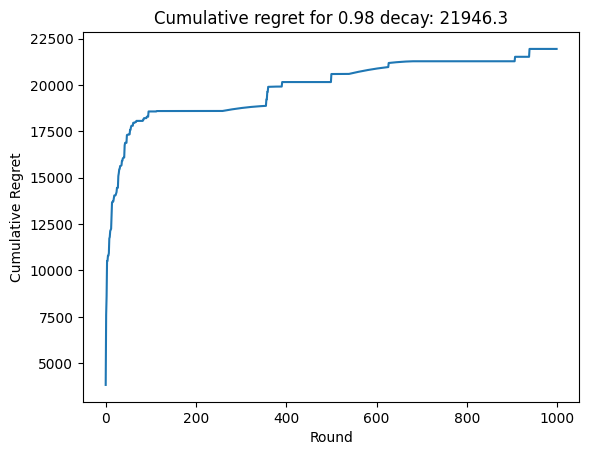

In [12]:
plt.plot(np.cumsum(regret))
zero_ninety_eight_decay_regret = np.cumsum(regret)[-1]
plt.xlabel("Round")
plt.ylabel("Cumulative Regret")
plt.title(f"Cumulative regret for 0.98 decay: {zero_ninety_eight_decay_regret:0.1f}")
summary_of_regrets['Regret with 0.98 decay rate'] = zero_ninety_eight_decay_regret 

Now we'll optimize the `decay_rate` hyperparameter using `optuna`.

In [13]:
import optuna

def objective(trial: optuna.Trial):
    np.random.seed(3)
    decay_rate = trial.suggest_float("decay_rate", 0.9, 1.0)
    regret = run_decay_simulation(decay_rate, oracle)
    return np.cumsum(regret)[-1]

study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=100)

/Users/cristiandagnino/Library/Caches/pypoetry/virtualenvs/bayesianbandits-B6ZK3PHb-py3.12/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[I 2024-11-03 13:04:47,762] A new study created in memory with name: no-name-cd809bc2-c512-4f7a-b7eb-d964ca3416f9
[I 2024-11-03 13:04:48,624] Trial 0 finished with value: 190760.5343790662 and parameters: {'decay_rate': 0.9034171584238047}. Best is trial 0 with value: 190760.5343790662.
[I 2024-11-03 13:04:49,505] Trial 1 finished with value: 21628.371999778683 and parameters: {'decay_rate': 0.990092398737714}. Best is trial 1 with value: 21628.371999778683.
[I 2024-11-03 13:04:50,768] Trial 2 finished with value: 272469.8071621899 and parameters: {'decay_rate': 0.9191846571846929}. Best is trial 1 with value: 21628.371999778683.
[I 2024-11-03 13:04:51,591] Trial 3 f

In [14]:
study.best_params, study.best_value

({'decay_rate': 0.991657010817268}, 20430.369537424045)

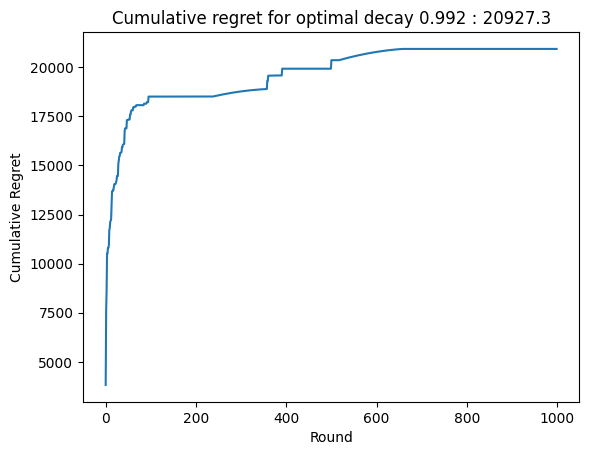

In [15]:
np.random.seed(3)
optimal_decay = study.best_params['decay_rate']
optimal_decay_regret = run_decay_simulation(decay_rate=optimal_decay, oracle=oracle)

plt.plot(np.cumsum(optimal_decay_regret))
plt.xlabel("Round")
plt.ylabel("Cumulative Regret")
plt.title(f"Cumulative regret for optimal decay {optimal_decay:0.3f} : {np.cumsum(optimal_decay_regret)[-1]:0.1f}")
summary_of_regrets['Regret with optimal decay rate'] = np.cumsum(optimal_decay_regret)[-1]

Bellow is a table summary of the four different scenarios / strategies that we tried.
We could get better results with the optimal decay rate than without decay.

Note that there is a lot of variation between runs, so we should run multiple runs with each strategy to verify how the distribution of the results work.

In [16]:
print(f"{'Strategy':<35} {'Regret':>12}")
print("-" * 50)
for strategy, regret in summary_of_regrets.items():
    print(f"{strategy:<35} {regret:>12.1f}")
print("-" * 50)



Strategy                                  Regret
--------------------------------------------------
Regret without drift                     21684.3
Regret without decay                     39599.6
Regret with 0.98 decay rate              21946.3
Regret with optimal decay rate           20927.3
--------------------------------------------------
